In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import KMeans
import copy

import sys
sys.path.append("lib")

import lib

import torch
torch.set_default_dtype(torch.float64)

from functorch import vmap
from torch.utils.data import DataLoader
import tqdm

/home/peiyi/mambaforge3/envs/rom/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


To do:

try small mu

for loop (convolve one basis at a time)

stop at every location (bandwidths, bubbles, smoothed basis, etc.) check after one iteration if the memory usage increase

In [2]:
device = torch.device("cuda")

In [3]:
coords_x, coords_y, _ = lib.utils.read_coords("2d_burger_data/time_step_0.csv")
coords = torch.stack((coords_x, coords_y), dim=1)

In [4]:
# dt = 0.004
# num_steps = 501
dt = 0.002
num_steps = 1001
num_nodes = coords_x.shape[0]

datas = lib.utils.read_data(num_steps, num_nodes, '2d_burger_data/time_step_', 'vel_0')
datas.shape

torch.Size([1001, 14641])

In [5]:
u_dot = lib.utils.u_dot(datas, dt)

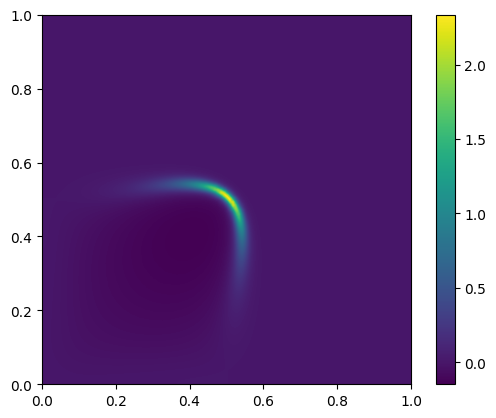

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = u_dot[455].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [7]:
datas = torch.hstack((datas[:-1], u_dot))
datas.shape

torch.Size([1000, 29282])

In [8]:
m = 50
clustering = KMeans(n_clusters=m, random_state=0, n_init="auto").fit(coords)

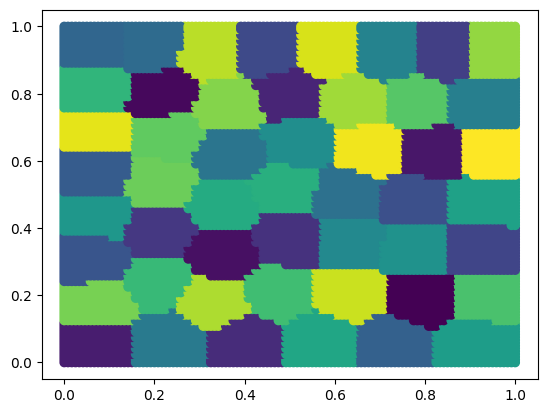

In [9]:
plt.scatter(coords_x, coords_y,c=clustering.labels_)

w: n x N

In [10]:
# # distance: N x mu
# # w: n x N ([0 element_size])
# # mu: number of neighbour elements
# def bubble(distance, w, mu):
#     n = w.shape[0]
#     window = torch.relu(-(distance.unsqueeze(0).expand(n, -1, -1)**2)/(w.unsqueeze(-1)*mu)**2 + 1)
#     window = window / torch.sum(window, dim=1, keepdim=True)
#     # n x N x mu
#     return window

In [11]:
# # x: n x N
# # neighbour_id: N x mu
# # w: n x N
# def convolve(x, neighbour_id, neighbour_distance, w, mu):
#     # n x N x mu
#     bubbles = bubble(neighbour_distance, w, mu)
#     return torch.sum(x[:, neighbour_id] * bubbles, dim=-1)

w: b x n x N

In [12]:
# # distance: N x mu
# # w: b x n x N ([0 element_size])
# # mu: number of neighbour elements
# def bubble(distance, w, mu):
#     n = w.shape[1]
#     b = w.shape[0]
#     window = torch.relu(-(distance.unsqueeze(0).unsqueeze(0).expand(b, n, -1, -1)**2)/(w.unsqueeze(-1)*mu)**2 + 1)
#     window = window / torch.sum(window, dim=1, keepdim=True)
#     # b x n x N x mu
#     return window

In [13]:
# # x(decoder): n x N
# # neighbour_id: N x mu
# # w: b x n x N
# def convolve(x, neighbour_id, neighbour_distance, w, mu):
#     b = w.shape[0]
#     # b x n x N x mu
#     bubbles = bubble(neighbour_distance, w, mu)
#     return torch.sum(x[:, neighbour_id].unsqueeze(0).expand(b,-1,-1,-1) * bubbles, dim=-1)


In [14]:
N = datas.shape[1] // 2
n = 20
# fixed support (length)
mu = int(np.ceil(N/200))
neighbour_distance, neighbour_id = lib.utils.topk_neighbours(coords, mu)

In [15]:
batch_size = 16
datas = datas.to(device)
train_data = DataLoader(datas, batch_size=batch_size, shuffle=True)

In [16]:
ed = lib.nrbs_n_m.EncoderDecoder(N=N, n=n, mu=mu, m=m, neighbour_id=neighbour_id, neighbour_distance=neighbour_distance, clustering_labels=torch.tensor(clustering.labels_).type(torch.LongTensor), device=device)

In [17]:
# ed.nrbs = torch.load('models/nrbs_n_m.pth')

In [18]:
ed.train(train_data_loader=train_data, epochs=100)

100%|██████████| 63/63 [00:08<00:00,  7.11it/s]


Loss = 1994.1210722637109


100%|██████████| 63/63 [00:08<00:00,  7.29it/s]


Itr 0, loss = 1397.3110572216808


100%|██████████| 63/63 [00:08<00:00,  7.23it/s]


Itr 1, loss = 1101.4926899593559


100%|██████████| 63/63 [00:08<00:00,  7.18it/s]


Itr 2, loss = 955.402917288913


100%|██████████| 63/63 [00:08<00:00,  7.08it/s]


Itr 3, loss = 858.1452307164473


100%|██████████| 63/63 [00:09<00:00,  6.95it/s]


Itr 4, loss = 800.8406745546947


100%|██████████| 63/63 [00:09<00:00,  6.93it/s]


Itr 5, loss = 726.5079353254928


100%|██████████| 63/63 [00:09<00:00,  6.81it/s]


Itr 6, loss = 679.8771267570362


100%|██████████| 63/63 [00:09<00:00,  6.76it/s]


Itr 7, loss = 649.8320077487102


100%|██████████| 63/63 [00:09<00:00,  6.86it/s]


Itr 8, loss = 610.241533152916


100%|██████████| 63/63 [00:09<00:00,  6.80it/s]


Itr 9, loss = 576.540907691418


100%|██████████| 63/63 [00:09<00:00,  6.83it/s]


Itr 10, loss = 546.1766314856669


100%|██████████| 63/63 [00:09<00:00,  6.88it/s]


Itr 11, loss = 523.8928173995697


100%|██████████| 63/63 [00:09<00:00,  6.61it/s]


Itr 12, loss = 503.40749915922345


100%|██████████| 63/63 [00:09<00:00,  6.86it/s]


Itr 13, loss = 484.65045556418323


100%|██████████| 63/63 [00:09<00:00,  6.80it/s]


Itr 14, loss = 467.7376709358115


100%|██████████| 63/63 [00:09<00:00,  6.91it/s]


Itr 15, loss = 454.60248148365656


100%|██████████| 63/63 [00:09<00:00,  6.86it/s]


Itr 16, loss = 440.2566134091133


100%|██████████| 63/63 [00:09<00:00,  6.73it/s]


Itr 17, loss = 424.7936761417846


100%|██████████| 63/63 [00:09<00:00,  6.88it/s]


Itr 18, loss = 415.6043292661872


100%|██████████| 63/63 [00:09<00:00,  6.86it/s]


Itr 19, loss = 401.9365447968441


100%|██████████| 63/63 [00:09<00:00,  6.83it/s]


Itr 20, loss = 392.23379063604557


100%|██████████| 63/63 [00:09<00:00,  6.67it/s]


Itr 21, loss = 381.91128533484454


100%|██████████| 63/63 [00:09<00:00,  6.80it/s]


Itr 22, loss = 373.2296981182169


100%|██████████| 63/63 [00:09<00:00,  6.86it/s]


Itr 23, loss = 365.5086014786806


100%|██████████| 63/63 [00:09<00:00,  6.73it/s]


Itr 24, loss = 355.9928951878965


100%|██████████| 63/63 [00:09<00:00,  6.87it/s]


Itr 25, loss = 348.7423786904984


100%|██████████| 63/63 [00:09<00:00,  6.90it/s]


Itr 26, loss = 343.9442874078056


100%|██████████| 63/63 [00:09<00:00,  6.88it/s]


Itr 27, loss = 336.4154228728599


100%|██████████| 63/63 [00:09<00:00,  6.83it/s]


Itr 28, loss = 331.735312321987


100%|██████████| 63/63 [00:09<00:00,  6.71it/s]


Itr 29, loss = 323.29484499193296


100%|██████████| 63/63 [00:09<00:00,  6.91it/s]


Itr 30, loss = 317.20142743623865


100%|██████████| 63/63 [00:09<00:00,  6.86it/s]


Itr 31, loss = 311.3111767953439


100%|██████████| 63/63 [00:09<00:00,  6.72it/s]


Itr 32, loss = 305.189914205258


100%|██████████| 63/63 [00:09<00:00,  6.56it/s]


Itr 33, loss = 300.9986673127554


100%|██████████| 63/63 [00:09<00:00,  6.90it/s]


Itr 34, loss = 296.25278464940425


100%|██████████| 63/63 [00:09<00:00,  6.89it/s]


Itr 35, loss = 291.01634854199386


100%|██████████| 63/63 [00:09<00:00,  6.81it/s]


Itr 36, loss = 285.89536839955


100%|██████████| 63/63 [00:09<00:00,  6.90it/s]


Itr 37, loss = 278.5335786876846


100%|██████████| 63/63 [00:10<00:00,  6.30it/s]


Itr 38, loss = 276.45598954388646


100%|██████████| 63/63 [00:09<00:00,  6.55it/s]


Itr 39, loss = 272.02624381041284


100%|██████████| 63/63 [00:09<00:00,  6.93it/s]


Itr 40, loss = 266.31951042369883


100%|██████████| 63/63 [00:09<00:00,  6.83it/s]


Itr 41, loss = 261.6832734929661


100%|██████████| 63/63 [00:09<00:00,  6.94it/s]


Itr 42, loss = 257.46123392809926


100%|██████████| 63/63 [00:09<00:00,  6.95it/s]


Itr 43, loss = 251.34696696413602


100%|██████████| 63/63 [00:09<00:00,  6.92it/s]


Itr 44, loss = 251.24982153454903


100%|██████████| 63/63 [00:09<00:00,  6.87it/s]


Itr 45, loss = 249.5731718771339


100%|██████████| 63/63 [00:09<00:00,  6.88it/s]


Itr 46, loss = 241.56794703218762


100%|██████████| 63/63 [00:09<00:00,  6.86it/s]


Itr 47, loss = 235.7143114221049


100%|██████████| 63/63 [00:09<00:00,  6.62it/s]


Itr 48, loss = 235.48437711517775


100%|██████████| 63/63 [00:09<00:00,  6.75it/s]


Itr 49, loss = 243.2522092765855


100%|██████████| 63/63 [00:09<00:00,  6.87it/s]


Itr 50, loss = 231.0989652140177


100%|██████████| 63/63 [00:09<00:00,  6.81it/s]


Itr 51, loss = 224.6391706371113


100%|██████████| 63/63 [00:09<00:00,  6.89it/s]


Itr 52, loss = 220.95139173626063


100%|██████████| 63/63 [00:09<00:00,  6.90it/s]


Itr 53, loss = 216.74467713668818


100%|██████████| 63/63 [00:09<00:00,  6.83it/s]


Itr 54, loss = 214.63555329660173


100%|██████████| 63/63 [00:09<00:00,  6.87it/s]


Itr 55, loss = 215.42894987000025


100%|██████████| 63/63 [00:09<00:00,  6.91it/s]


Itr 56, loss = 211.4977570858081


100%|██████████| 63/63 [00:09<00:00,  6.87it/s]


Itr 57, loss = 206.74003566848242


100%|██████████| 63/63 [00:09<00:00,  6.76it/s]


Itr 58, loss = 203.54970444721926


100%|██████████| 63/63 [00:09<00:00,  6.91it/s]


Itr 59, loss = 201.12903941641864


100%|██████████| 63/63 [00:09<00:00,  6.89it/s]


Itr 60, loss = 203.07079720621104


100%|██████████| 63/63 [00:09<00:00,  6.88it/s]


Itr 61, loss = 197.63078885602442


100%|██████████| 63/63 [00:09<00:00,  6.73it/s]


Itr 62, loss = 193.2441786022516


100%|██████████| 63/63 [00:10<00:00,  6.15it/s]


Itr 63, loss = 190.595002480628


100%|██████████| 63/63 [00:09<00:00,  6.88it/s]


Itr 64, loss = 191.1737190856523


100%|██████████| 63/63 [00:09<00:00,  6.93it/s]


Itr 65, loss = 188.5767107885872


100%|██████████| 63/63 [00:09<00:00,  6.82it/s]


Itr 66, loss = 185.35363300485326


100%|██████████| 63/63 [00:09<00:00,  6.84it/s]


Itr 67, loss = 181.57112461536116


100%|██████████| 63/63 [00:09<00:00,  6.87it/s]


Itr 68, loss = 177.91145383269978


100%|██████████| 63/63 [00:09<00:00,  6.92it/s]


Itr 69, loss = 179.47406721041455


100%|██████████| 63/63 [00:09<00:00,  6.91it/s]


Itr 70, loss = 179.80329258271664


100%|██████████| 63/63 [00:09<00:00,  6.89it/s]


Itr 71, loss = 178.01649484409776


100%|██████████| 63/63 [00:09<00:00,  6.82it/s]


Itr 72, loss = 172.65393876481258


100%|██████████| 63/63 [00:09<00:00,  6.79it/s]


Itr 73, loss = 170.88214954605107


100%|██████████| 63/63 [00:09<00:00,  6.87it/s]


Itr 74, loss = 173.02837629061872


  3%|▎         | 2/63 [00:02<01:21,  1.34s/it]


KeyboardInterrupt: 

In [19]:
ed.nrbs = torch.load('models/nrbs_n_m.pth')

In [20]:
approximates = ed(datas[999:1001, :N].to(device))
approximates.shape

torch.Size([1, 14641])

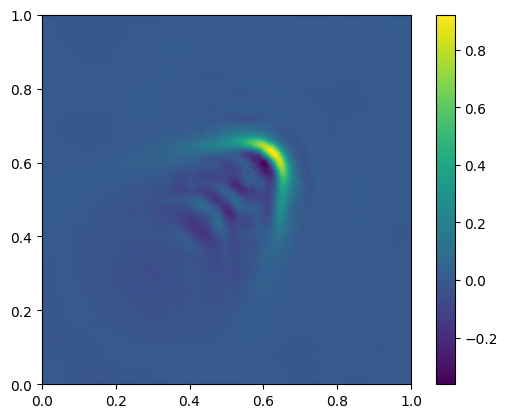

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = approximates[0].detach().cpu().tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

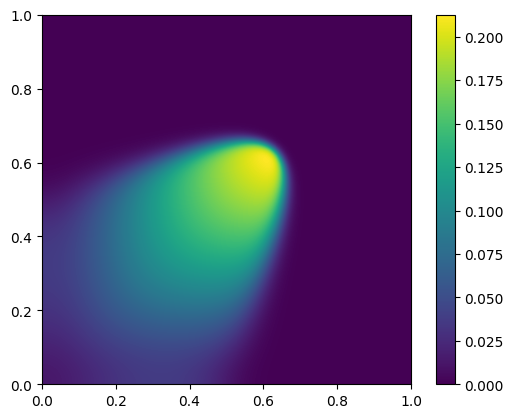

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = datas[999, :N].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

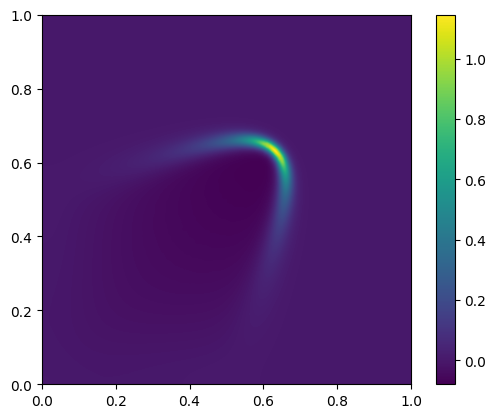

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = datas[999, N:].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [24]:
encoded = ed.nrbs.encode(datas[999:1001, :N].to(device))
encoded.shape

torch.Size([1, 20])

In [25]:
bandwidths = torch.sigmoid(ed.nrbs.bandwidth_layers(encoded[0]))
bandwidths = (1 / 60 - 10 / 60 / ed.nrbs.mu) * bandwidths + 10 / 60 / ed.nrbs.mu
bandwidths = bandwidths.reshape(n, m)
bandwidths = bandwidths[:, ed.nrbs.clustering_labels]

convolved_bases = ed.nrbs.convolve(
                ed.nrbs.decoder.weight,
                ed.nrbs.neighbour_id,
                ed.nrbs.neighbour_distance,
                bandwidths,
                ed.nrbs.mu,
            )

bandwidths = bandwidths.detach().cpu()
convolved_bases = convolved_bases.detach().cpu()

In [26]:
convolved_bases.shape

torch.Size([20, 14641])

In [27]:
torch.min(bandwidths)

tensor(0.0023)

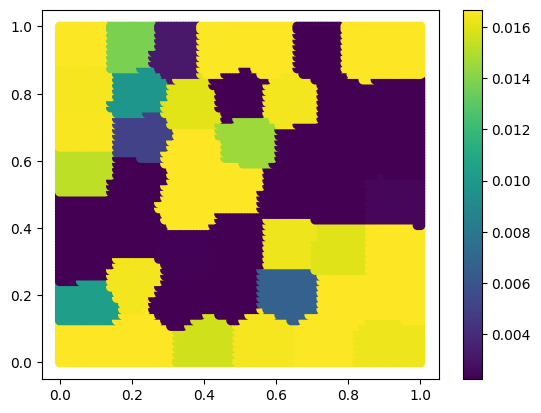

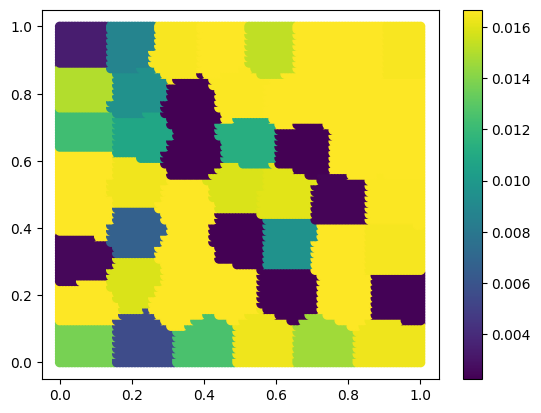

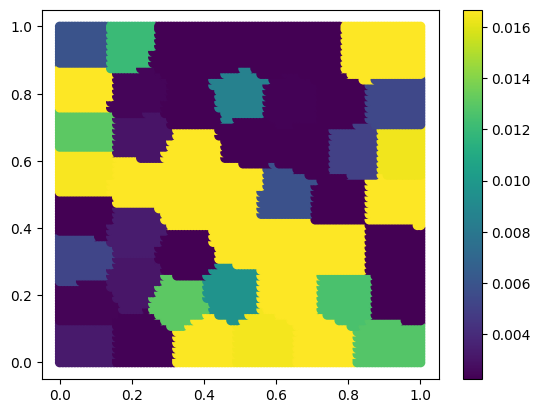

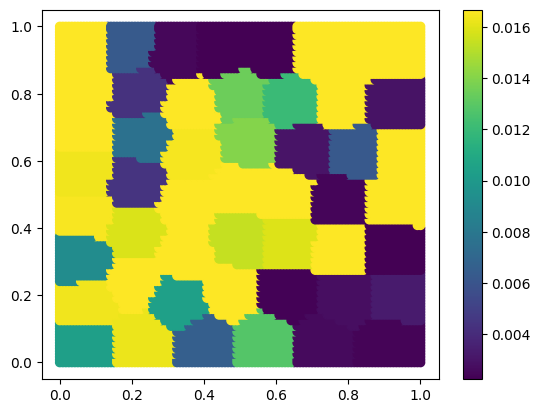

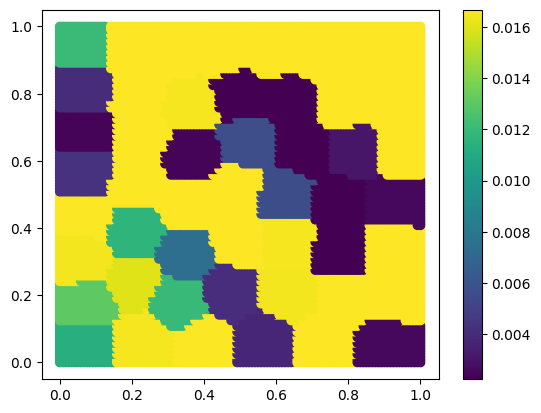

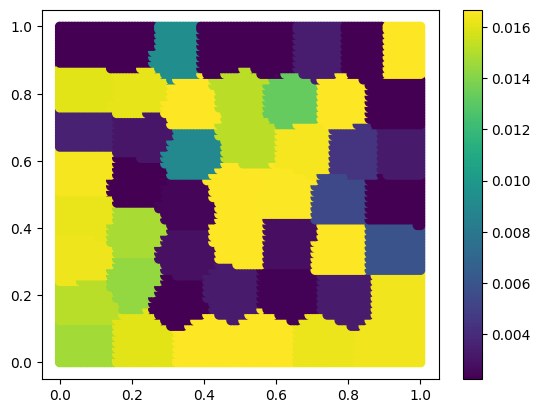

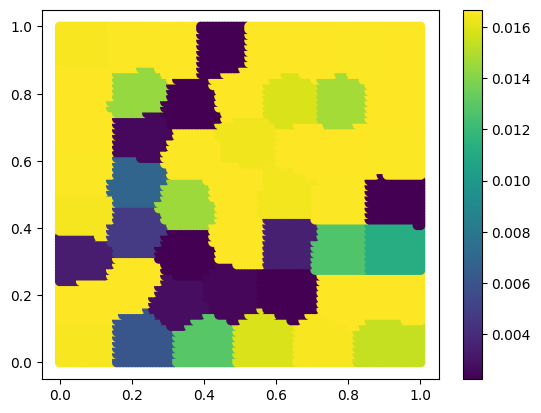

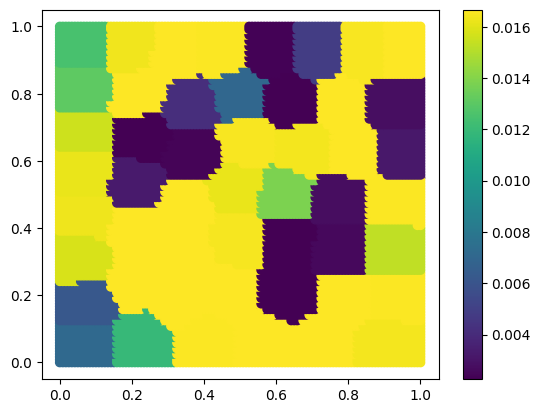

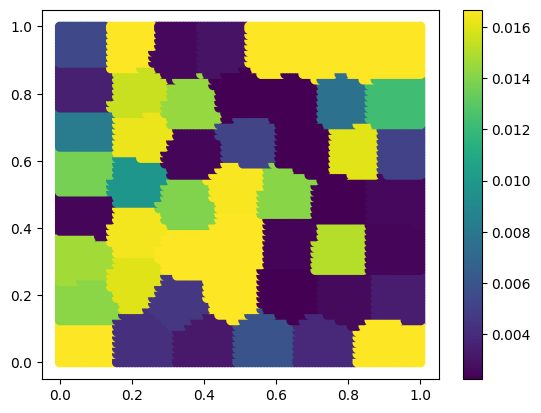

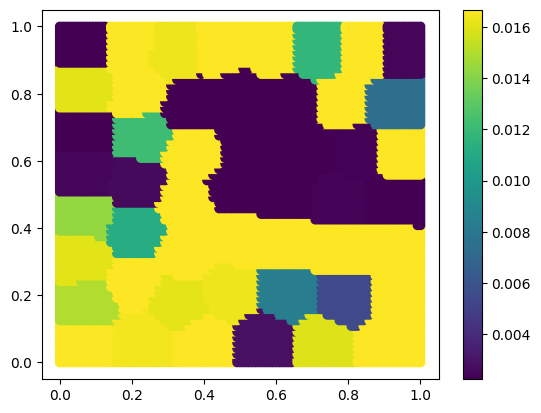

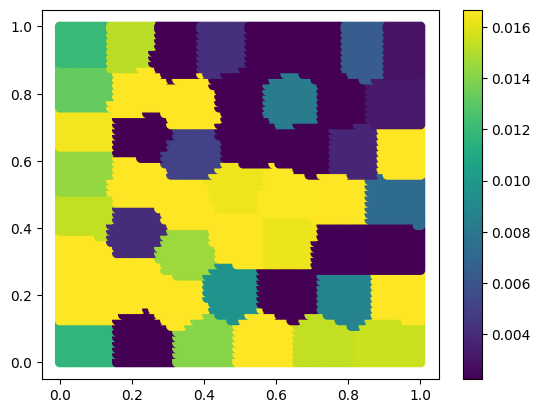

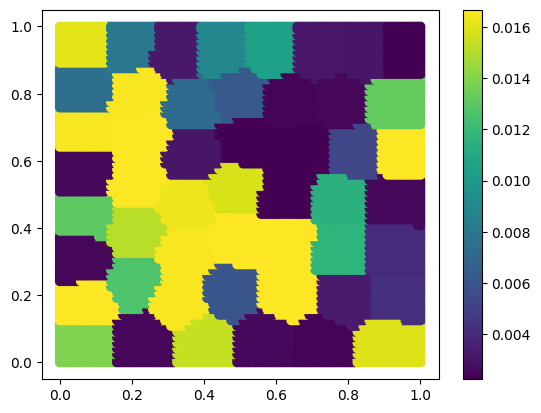

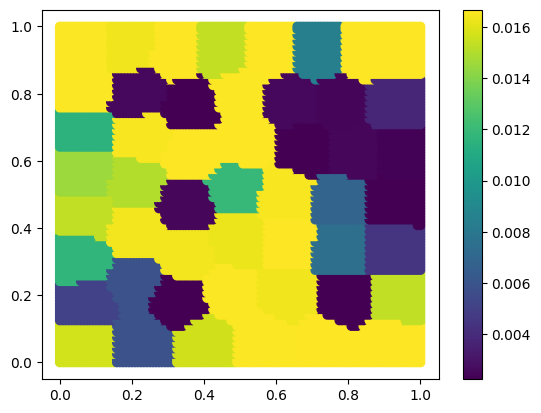

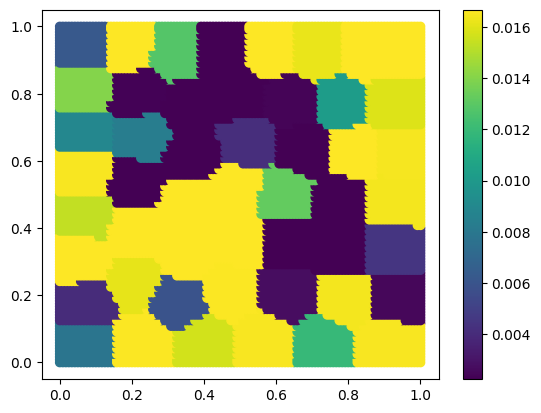

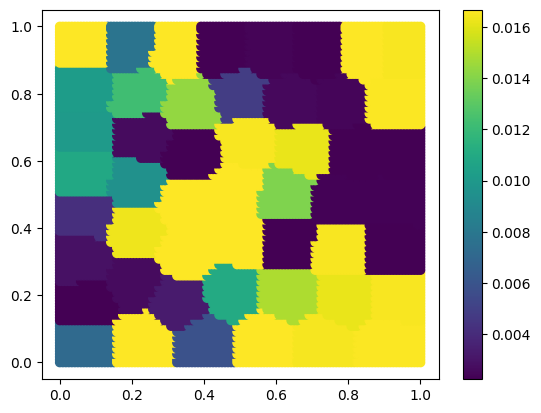

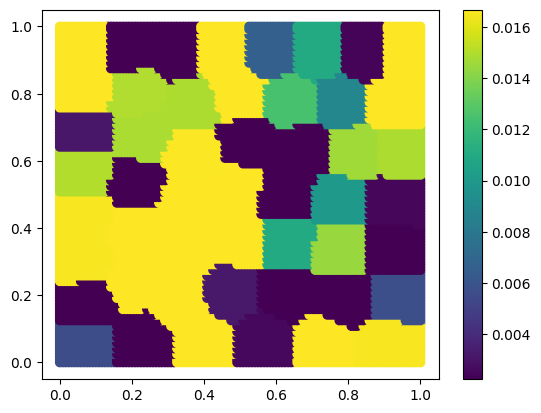

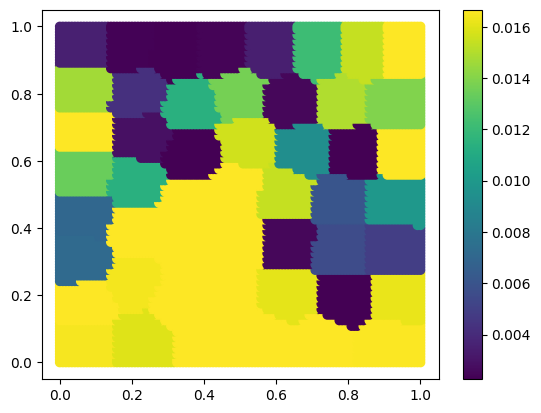

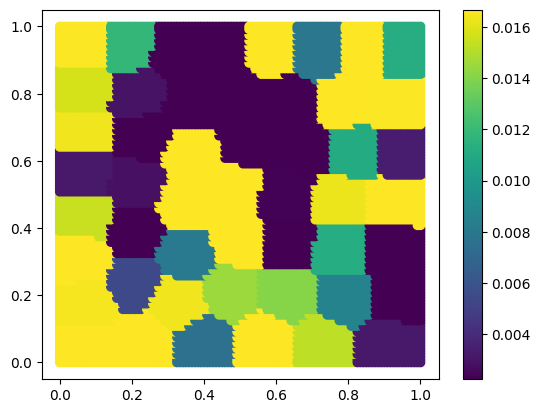

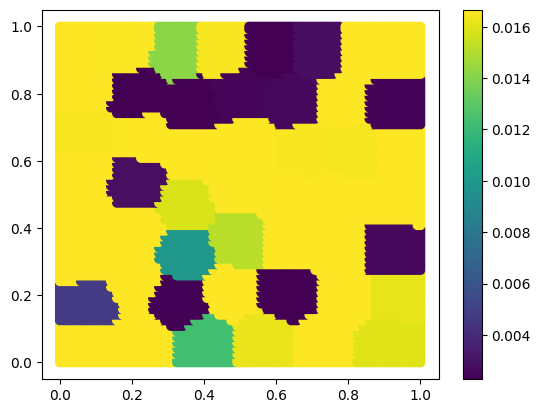

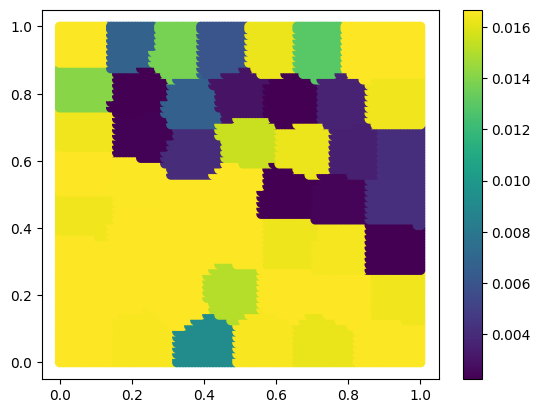

In [28]:
for basis_id in range(n):
    plt.scatter(coords_x, coords_y,c=bandwidths[basis_id])
    plt.colorbar()
    plt.show()

In [29]:
bs_n_m = torch.sigmoid(ed.nrbs.bandwidth_layers(encoded[0])) / 60
bs_n_m = bs_n_m.reshape(n, m)
bs_n_m = bs_n_m[:, ed.nrbs.clustering_labels]

In [30]:
bubbles = ed.nrbs.bubble(neighbour_distance.to(device), bs_n_m, mu)

In [31]:
bs_n_m

tensor([[0.0166, 0.0166, 0.0166,  ..., 0.0167, 0.0167, 0.0167],
        [0.0132, 0.0132, 0.0132,  ..., 0.0165, 0.0165, 0.0165],
        [0.0011, 0.0011, 0.0011,  ..., 0.0166, 0.0166, 0.0166],
        ...,
        [0.0167, 0.0167, 0.0167,  ..., 0.0104, 0.0104, 0.0104],
        [0.0167, 0.0167, 0.0167,  ..., 0.0167, 0.0167, 0.0167],
        [0.0167, 0.0167, 0.0167,  ..., 0.0167, 0.0167, 0.0167]],
       device='cuda:0', grad_fn=<IndexBackward0>)

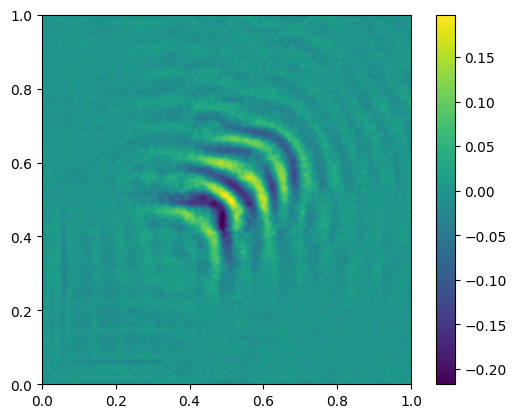

In [32]:
z = ed.nrbs.decoder.weight[0].tolist()

vmin = min(z)
vmax = max(z)

 # target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1],vmin=vmin,vmax=vmax)
plt.colorbar()
plt.show()


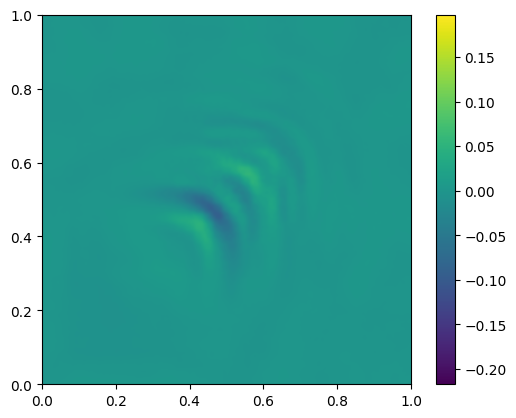

In [33]:
z = convolved_bases[0].tolist()
# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1],vmin=vmin,vmax=vmax)
plt.colorbar()
plt.show()

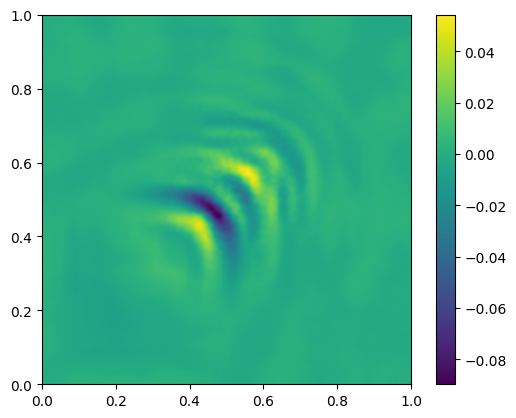

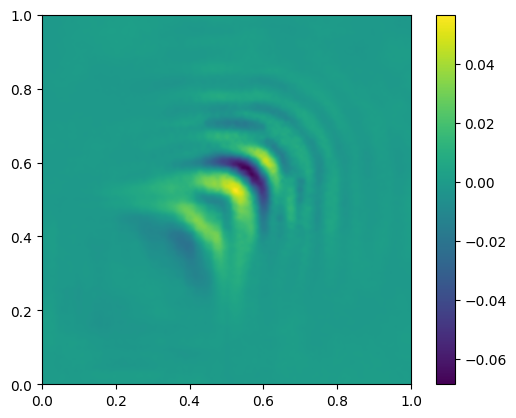

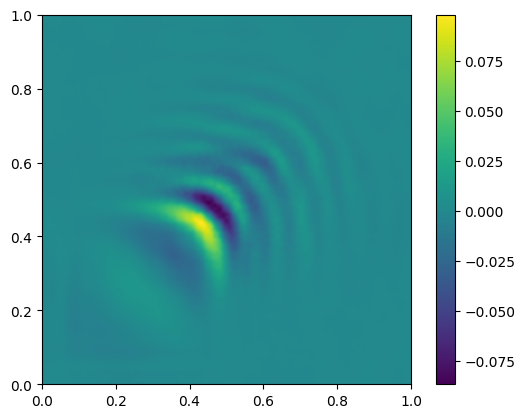

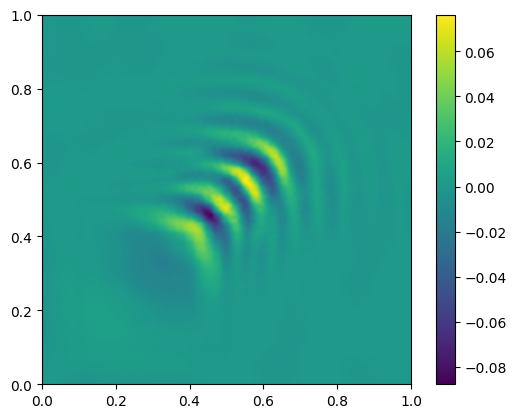

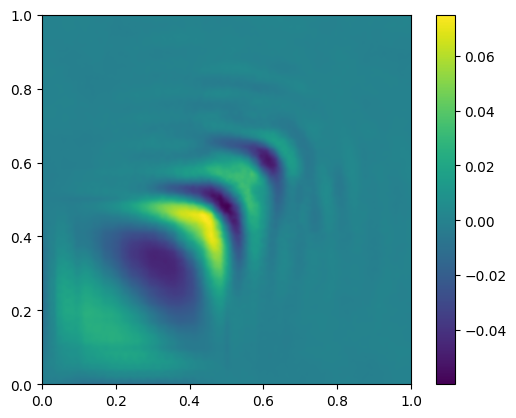

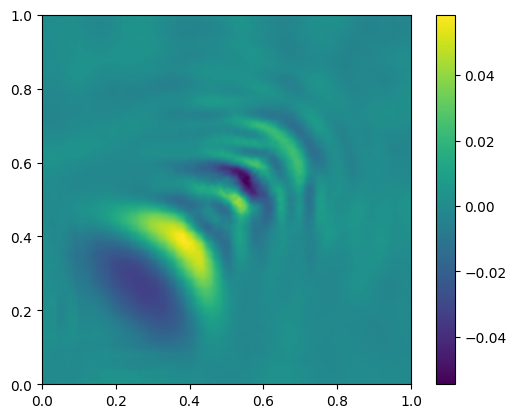

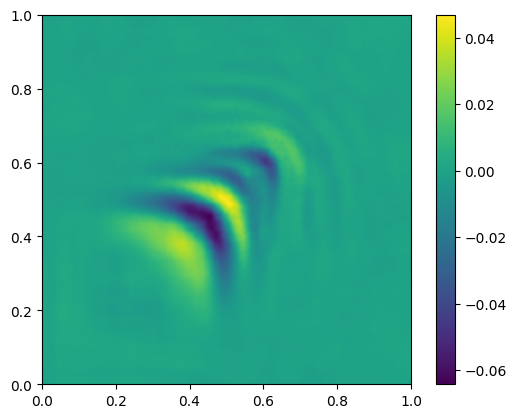

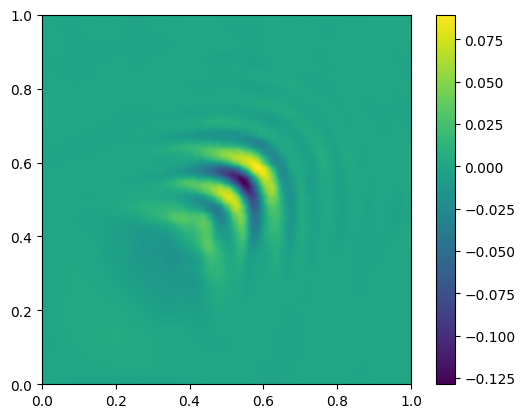

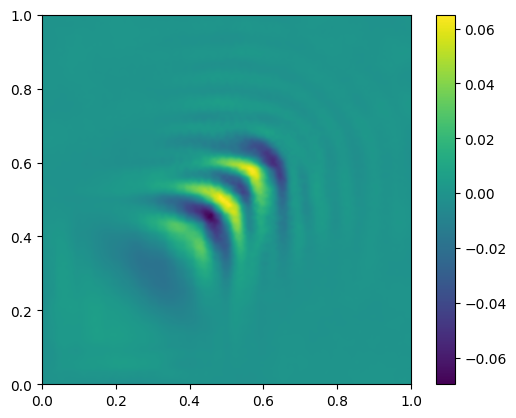

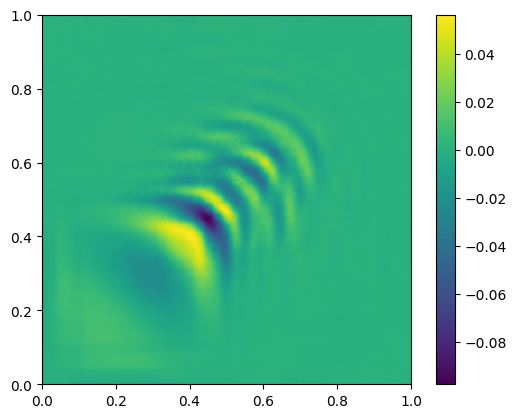

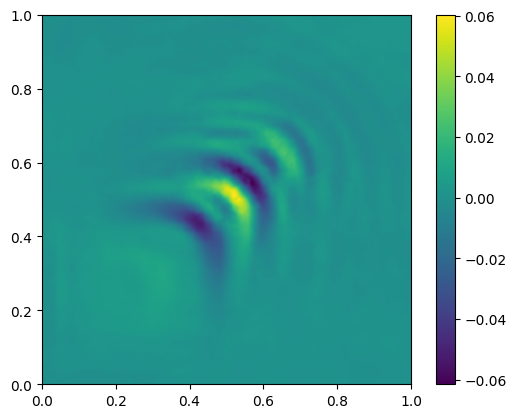

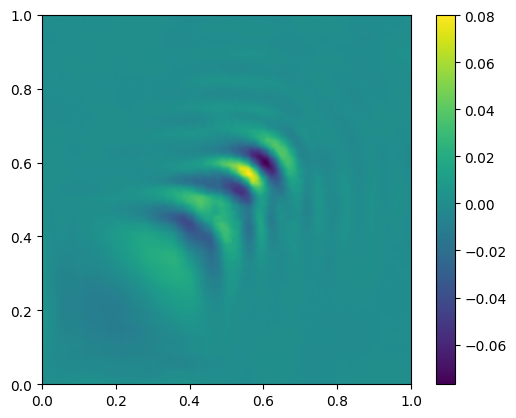

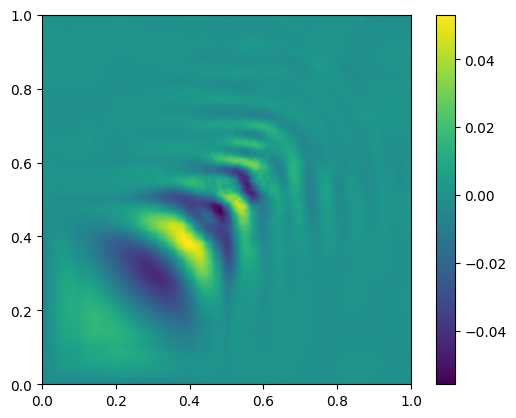

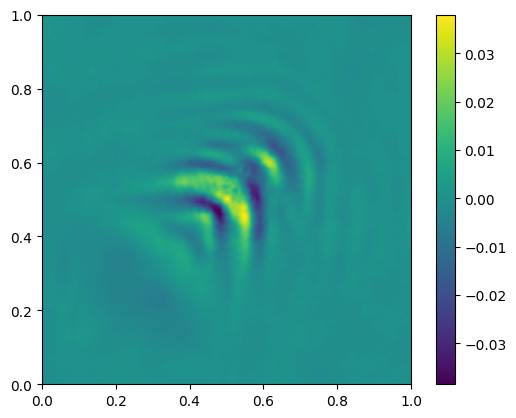

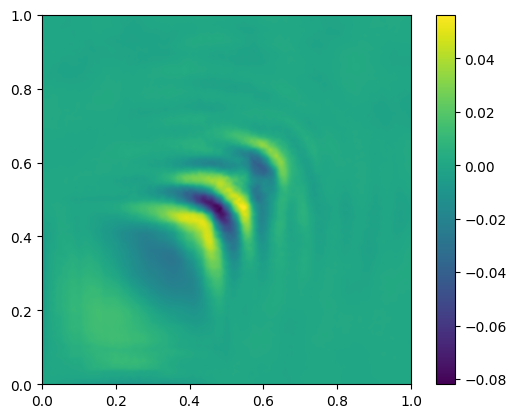

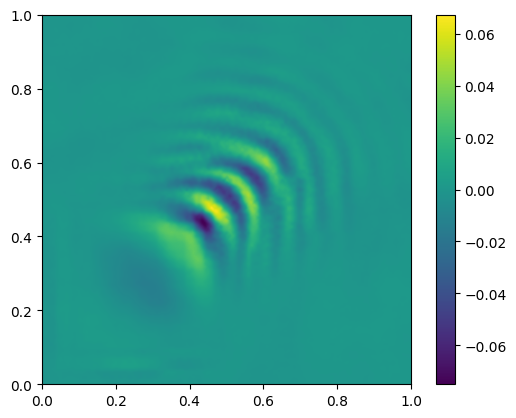

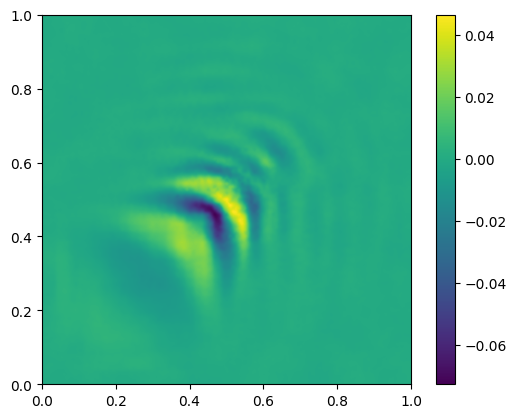

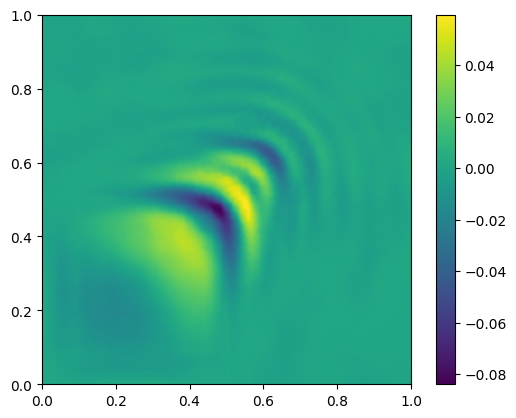

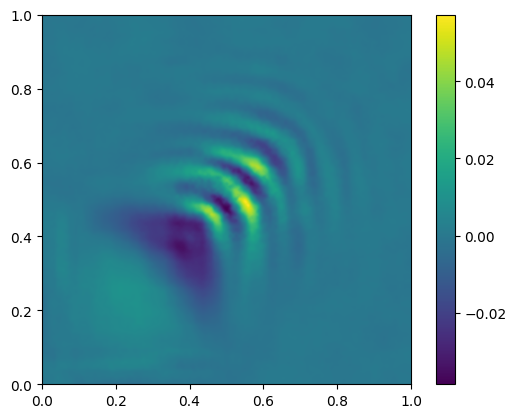

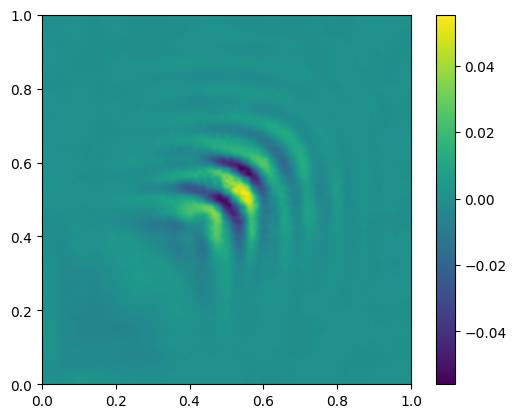

In [34]:
for basis_id in range(n):
    z = convolved_bases[basis_id].tolist()

    # target grid to interpolate to
    xi = yi = np.linspace(0,1.0,1200)
    xi,yi = np.meshgrid(xi,yi)

    # set mask
    # mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

    # interpolate
    zi = griddata((x,y),z,(xi,yi),method='cubic')

    plt.imshow(zi,origin='lower', extent=[0,1,0,1])
    plt.colorbar()
    plt.show()

In [35]:
# bws = ed.nrbs.bandwidth_layer(ed.nrbs.encode(datas[499:501].to(device)))
# bws = torch.sigmoid(bws)

In [36]:
# bws = ed.nrbs.get_bandwidth(ed.nrbs.encode(datas[499:501].to(device)))

In [37]:
# # data coordinates and values
# z = bws[0].detach().cpu().tolist()

# # target grid to interpolate to
# xi = yi = np.linspace(0,1.0,1200)
# xi,yi = np.meshgrid(xi,yi)

# # set mask
# # mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# # interpolate
# zi = griddata((x,y),z,(xi,yi),method='cubic')

# plt.imshow(zi,origin='lower', extent=[0,1,0,1])
# plt.colorbar()